In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [3]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [5]:
import re

In [6]:
df = pd.read_csv("train.csv")
df_train = pd.DataFrame(df[:25000])
df_val = pd.DataFrame(df[25000:])

In [7]:
df_train

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
24995,24996,0,"if you have any #questions, give us a #call, w..."
24996,24997,0,"last day of school! practice today, game tomor..."
24997,24998,0,go have a listen to my new song being released...
24998,24999,0,bad day. all my 'friends' were being very mean...


In [8]:
max_words = 2000
max_len = 15
num_classes = 1

epochs = 10
batch_size = 512
print_batch_n = 100

In [9]:
sw = set(get_stop_words("en"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("not\s", "not", txt)
    txt = re.sub("dont\s", "dont", txt)
    txt = re.sub("doesnt\s", "doesnt", txt)
    txt = re.sub("didnt\s", "didnt", txt)
    txt = re.sub("havent\s", "havent", txt)
    txt = re.sub("hasnt\s", "hasnt", txt)
    txt = [morpher.parse(word)[0].normal_form \
           for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['tweet'] = df_train['tweet'].apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].apply(preprocess_text)

In [10]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [11]:
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Николай\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [13]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [14]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [15]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [16]:
x_train = np.asarray([text_to_sequence(text, max_len) \
                      for text in df_train["tweet"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len)\
                    for text in df_val["tweet"]], dtype=np.int32)

In [36]:
x_train.shape

(25000, 15)

In [18]:
x_val.shape

(6962, 15)

# GRU

In [19]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [20]:
class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        if self.target is not None:
            y = self.target[index] 
        else:
            y = None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [21]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [22]:
model = GRUFixedLen(max_words, 128, 20, use_last=False)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.BCELoss()

In [24]:
model.train()
th = 0.6

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1]
        test_outputs = model(data[0])
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

Epoch [1/10]. Step [49/49]. Loss: 0.273. Acc: 0.930. Test loss: 0.187. Test acc: 0.930
Epoch [2/10]. Step [49/49]. Loss: 0.157. Acc: 0.932. Test loss: 0.159. Test acc: 0.934
Epoch [3/10]. Step [49/49]. Loss: 0.142. Acc: 0.942. Test loss: 0.132. Test acc: 0.941
Epoch [4/10]. Step [49/49]. Loss: 0.115. Acc: 0.951. Test loss: 0.135. Test acc: 0.944
Epoch [5/10]. Step [49/49]. Loss: 0.116. Acc: 0.956. Test loss: 0.140. Test acc: 0.948
Epoch [6/10]. Step [49/49]. Loss: 0.123. Acc: 0.960. Test loss: 0.151. Test acc: 0.948
Epoch [7/10]. Step [49/49]. Loss: 0.092. Acc: 0.963. Test loss: 0.186. Test acc: 0.949
Epoch [8/10]. Step [49/49]. Loss: 0.106. Acc: 0.965. Test loss: 0.109. Test acc: 0.947
Epoch [9/10]. Step [49/49]. Loss: 0.066. Acc: 0.968. Test loss: 0.145. Test acc: 0.948
Epoch [10/10]. Step [49/49]. Loss: 0.108. Acc: 0.968. Test loss: 0.105. Test acc: 0.947
Training is finished!


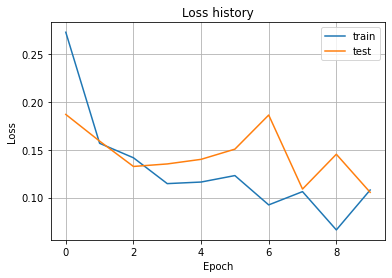

In [25]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()

# LSTM

In [26]:
import torchmetrics

In [27]:
class LSTMFixedLen(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)

        lstm_out, ht = self.lstm(x) 
        

        if self.use_last:
            last_tensor = lstm_out[:,-1,:]  
        else:
            last_tensor = torch.mean(lstm_out[:,:], dim=1)  
    
        out = self.linear(last_tensor)
        
        return torch.sigmoid(out)

In [28]:
model_lstm = LSTMFixedLen(max_words, 128, 128, use_last=False)

In [29]:
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [30]:
model_lstm.train()

train_loss_history = []
valid_loss_history = []

train_acc_history_lstm = []
valid_acc_history_lstm = []
train_acc = torchmetrics.Accuracy(task = 'binary')
test_acc = torchmetrics.Accuracy(task = 'binary')

In [31]:
for epoch in range(epochs): 
    model_lstm.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        
        # подсчет метрики на обучении
        train_acc(outputs.squeeze(), labels)
        
    # выводим статистику о процессе обучения
    model_lstm.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {train_acc.compute().item():.3f}', end='. ')

    train_loss_history.append(loss)
    train_acc_history_lstm.append(train_acc.compute().item())
    train_acc.reset()

    
    # выводим статистику на тестовых данных
    for j, data in enumerate(val_loader):
        test_labels = data[1]
        test_outputs = model_lstm(data[0])
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        
        # подсчет метрики на тесте
        test_acc(test_outputs.squeeze(), test_labels)

    print(f'Test loss: {test_loss:.3f}. Test acc: {test_acc.compute().item():.3f}')
    valid_loss_history.append(test_loss.item())
    valid_acc_history_lstm.append(test_acc.compute().item())
    test_acc.reset()
    
print('Training is finished!')

Epoch [1/10]. Step [49/49]. Loss: 0.237. Acc: 0.930. Test loss: 0.224. Test acc: 0.930
Epoch [2/10]. Step [49/49]. Loss: 0.218. Acc: 0.930. Test loss: 0.225. Test acc: 0.930
Epoch [3/10]. Step [49/49]. Loss: 0.263. Acc: 0.930. Test loss: 0.238. Test acc: 0.930
Epoch [4/10]. Step [49/49]. Loss: 0.170. Acc: 0.932. Test loss: 0.152. Test acc: 0.939
Epoch [5/10]. Step [49/49]. Loss: 0.133. Acc: 0.944. Test loss: 0.171. Test acc: 0.943
Epoch [6/10]. Step [49/49]. Loss: 0.142. Acc: 0.949. Test loss: 0.181. Test acc: 0.945
Epoch [7/10]. Step [49/49]. Loss: 0.204. Acc: 0.954. Test loss: 0.172. Test acc: 0.946
Epoch [8/10]. Step [49/49]. Loss: 0.124. Acc: 0.956. Test loss: 0.166. Test acc: 0.946
Epoch [9/10]. Step [49/49]. Loss: 0.078. Acc: 0.958. Test loss: 0.142. Test acc: 0.947
Epoch [10/10]. Step [49/49]. Loss: 0.107. Acc: 0.960. Test loss: 0.179. Test acc: 0.949
Training is finished!


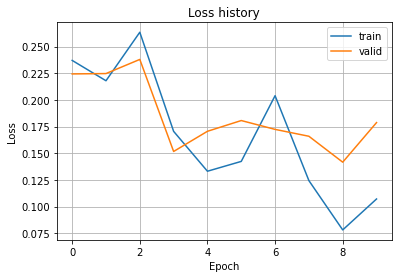

In [32]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

# Вывод

В целом модель GRU показывает при сходных параметрах лучший результат. 
Были опробованы разные комбинации из входных данных (max_len) и параметров
моделей, был увеличен порог - th. Настойки оптимизатора не менялись.
Предпочтительно выбирать цепочки слов менее 20.